# Spectroscopy of a two qubit and 3 cavity system (2D), <mark>without thermal loss</mark>


1. **Introduction**
2. **Problem parameters**
3. **Setting up the operators and the Hamiltonian's**
    * **Defining functions**
    * **Defining the operators for the cavties and qubits**
    * **Defining the Hamiltonians for the qubit-cavity system**
4. **Frequency spectrum of the coupled system**
5. **Evolving qubit 1 in the system with time (no thermal losses)**

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 2nd July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is shown in the schematic diagram below [[McKay et al.]](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

The code calculates the eigen modes for such a system when the qubit 1 frequency is changed. 

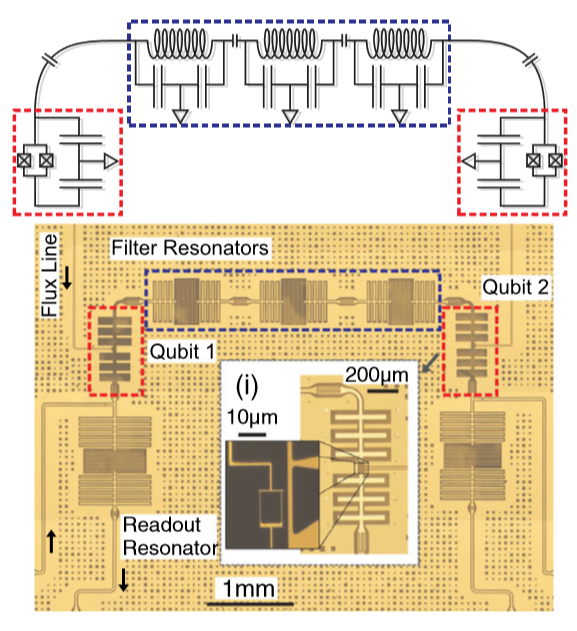

In [27]:
from IPython.display import Image
Image(filename='images/c_qubit_circuit.PNG')

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from math import pi
from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [29]:
"""------------- FREQUENCIES --------------------"""
w_q1 = 2*pi*6.5;    # Qubit 1 frequency
w_q2 = 2*pi*6.8;    # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1      # Resonator/ Filter frequency
"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.118    # Filter-filter coupling
g_f2 = 2*pi*0.344 
g_q1f = 2*pi*0.135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.415   # qubit 2-fitler coupling

numF = 3            # number of filters
N = 2               # number of fock states 

kappa = 1.0/0.129   # cavity dissipation rate
n_th_a = 0.063      # avg. no. of thermal bath excitation
r1 = 0.0075           # qubit relaxation rate
r2 = 0.0025           # qubit dephasing rate

times = np.linspace(0,100,800)

## 3. Setting up the operators and the Hamiltonian's

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator


### 3.1. Defining functions

In [30]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m1*m2.dag()

### 3.2 Defining the operators for the cavties and qubits

In [31]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

# collapse operators
c_ops = []

### 3.3 Defining the Hamiltonians for the qubit-cavity system

In [32]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = 0.5*sz1       
Hq2 = 0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# Qubit 1 -independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf + w_q2*Hq2
 
H = w_f*Hf + H_f12 + Hqf + w_q1*Hq1 + w_q2*Hq2  # Resultant Hamiltonian

## 4. Frequency spectrum of the coupled system

### 4.1 Looking at the eigen-energies 

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6d079d0>)

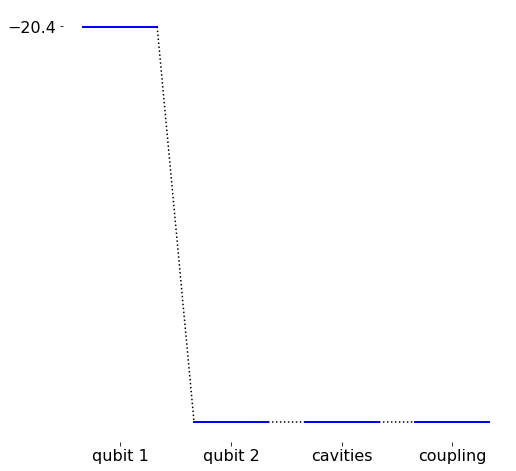

In [33]:
# plotting the energy level diagram for the 1st excited state
label_list = ['qubit 1', 'qubit 2', 'cavities', 'coupling']
Hlist = [w_q1*Hq1, w_q2*Hq2, w_f*Hf, Hqf]
fig,ax = plt.subplots(figsize=(8,8))

plot_energy_levels(Hlist, 1, label_list, True, (8,12), fig, ax)

In [34]:
# range of qubit 1 frequencies
w_q1List = np.linspace(.50,8,800)*2*pi

evals_mat = compute(w_q1List, H0, N, sz1)

In [35]:
def compute(w_qList, H_q1, N, sz1):
  """
  Computes the Eigen-vales and states for a given qubit frequency
  @param w_qList :: range of qubit frequencies
  @param H_q1 :: Qubit 1 independent Hamiltonian 
  @param N :: Number of Fock states
  @param sz1 :: z matrix for qubit 1
  """
  evals_mat = np.zeros((len(w_qList), 32))
  for i, w_qi in enumerate(w_qList):
    H = H_q1 + 0.5*w_qi*sz1
    evals, evecs = H.eigenstates()
    evals_mat[i,:] = evals
  return evals_mat  

Text(0.5, 1.0, 'Energy Spectrum (2 qubits and 3 cavities) \n')

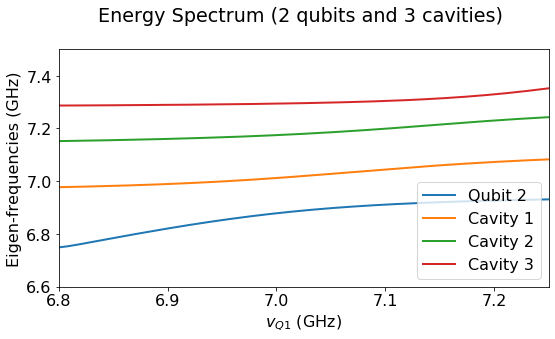

In [42]:
fig,ax = plt.subplots(figsize=(8,5), tight_layout=True)
labels = ["Qubit 2", "Cavity 1", "Cavity 2", "Cavity 3"]
eval_index = [ 2, 3, 4, 5]
for i, n in enumerate(eval_index):
    ax.plot(w_q1List / (2 * pi), (evals_mat[:, n]-evals_mat[:, 0])/ (2 * pi), lw=2, label=labels[i])
ax.set_xlabel(r'$v_{Q1}$ (GHz)')
ax.set_ylim(6.6, 7.5)
ax.set_xlim(6.8, 7.25)
ax.legend()
ax.set_ylabel('Eigen-frequencies (GHz)')
ax.set_title('Energy Spectrum (2 qubits and 3 cavities) \n')

## 5. Evolving qubit 1 in the system with time (no thermal losses)

In [37]:

    
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,0), basis(2,1))

output = mesolve(H, psi0, times, [], [n1, n2, numOp(a1), numOp(a2), numOp(a3)])

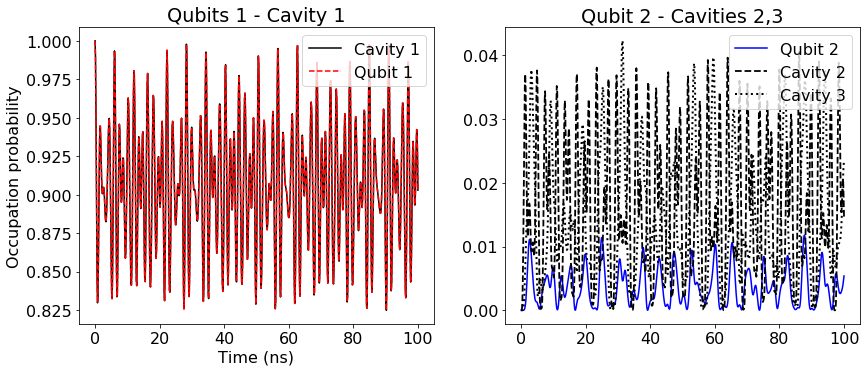

In [38]:
fig = plt.figure(figsize=(14,12))

# qubit 1 - Cavity 1
ax1 = fig.add_subplot(2,2, 1)
ax1.plot(times, output.expect[0], 'k', label="Cavity 1")
ax1.plot(times, output.expect[0], 'r--', label="Qubit 1")
ax1.set_xlabel('Time (ns)');
ax1.set_ylabel('Occupation probability');
ax1.set_title('Qubits 1 - Cavity 1');
ax1.legend(loc="upper right")

# qubit 2 - Cavity 2, 3
ax2 = fig.add_subplot(2,2, 2)
ax2.plot(times, output.expect[1], 'b-', label="Qubit 2")
ax2.plot(times, output.expect[3], 'k--', linewidth=1.8, label="Cavity 2")
ax2.plot(times, output.expect[4], 'k:', linewidth=2, label="Cavity 3")
ax2.set_title('Qubit 2 - Cavities 2,3');
ax2.legend(loc="upper right")

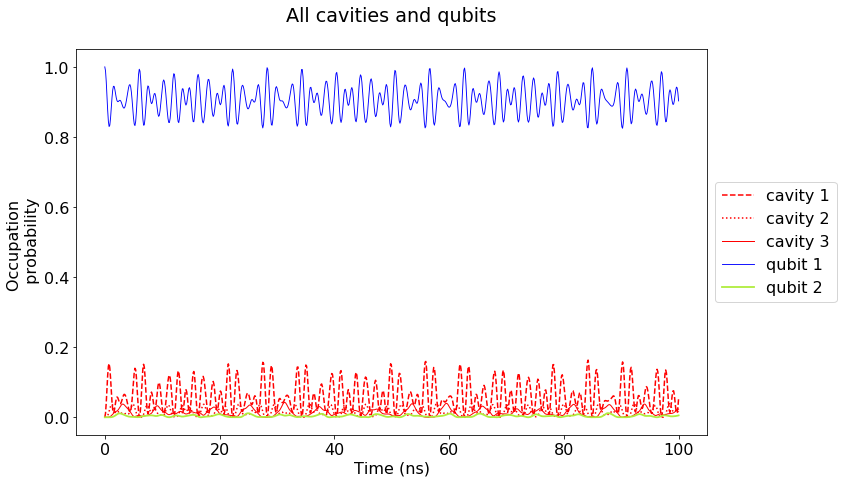

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(12,7))

#axes.plot(times, output.expect[0] + output.expect[1] + output.expect[2] + output.expect[3] + output.expect[4], 'k--', linewidth=1.5, label="Total Probability")
axes.plot(times, output.expect[2], 'r--', linewidth=1.5, label="cavity 1")
axes.plot(times, output.expect[3], 'r:', linewidth=1.5, label="cavity 2")
axes.plot(times, output.expect[4], 'r', linewidth=1, label="cavity 3")
axes.plot(times, output.expect[0], 'b', linewidth=0.9, label="qubit 1")
axes.plot(times, output.expect[1], '#b0ed3e', linewidth=1.8, label="qubit 2")
axes.set_xlabel("Time (ns)")
axes.set_ylabel("Occupation \n probability")
axes.set_title("All cavities and qubits\n")
axes.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

fig.tight_layout()

### Versions

In [40]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.1
Numpy,1.16.4
SciPy,1.2.1
matplotlib,3.1.0
Cython,0.29.12
Number of CPUs,4
BLAS Info,OPENBLAS
IPython,7.5.0
Python,"3.7.3 (v3.7.3:ef4ec6ed12, Mar 25 2019, 21:26:53) [MSC v.1916 32 bit (Intel)]"
OS,nt [win32]
